# Bell Pepper Leaf Disease Classification using Transfer Learning by Fine-Tuning VGG16 Pre-trained Model.

### Introduction

In this notebook, we'll fine-tune a pre-trained VGG16 model and use it to predict bell pepper leaf disease. VGG16 is one of the State-Of-The-Art pre-trained CNN models that was trained on IMAGENET 1000 classes imageset.

Let's dive in.

### Import necessary libraries 

In [125]:
import os
import cv2
import PIL.Image as Image
import pandas as pd
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten

In [73]:
from PIL import Image
from IPython.display import display
from IPython.display import Image as _Imgdis

This dataset was taken from this Kaggle link.
https://www.kaggle.com/datasets/lavaman151/plantifydr-dataset

### Referencing our train and test data.

In [74]:
train_dir ='./Bell pepper/train'
test_dir = './Bell pepper/test'

VGG16 expects images of size 224 by 224, so we need to resize our images to this size.


In [75]:
IMAGE_SIZE = [224, 224]

Here, we want to view a sample of our images. We'll use tf.keras image preprocessing library to load the image.

In [76]:
img1 = image.load_img('./Bell pepper/train/Bell pepper Bacterial spot/BacterialSpot(6).JPG')

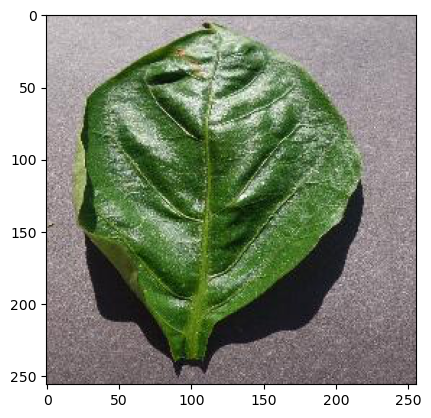

In [77]:
plt.imshow(img1)

### Building the model.

First, we'll download the VGG16 model from tensorflow keras applications that we imported earlier and store it in a variable.

We don't want to include the last layer because its trained to classify 1000 classes of images. Our data has only 2 classes.

In [78]:

IMAGE_SHAPE=(224, 224, 3)
vgg = VGG16(input_shape=IMAGE_SHAPE, weights='imagenet', include_top=False)


In [79]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_4')>

#### Freezing some of the vgg16 layers.

All the layers in VGG16 come as trainable by default. This means that we have to train all the layers completely from scratch. This will be a lot of computation. Using transfer learning, we want to retain the trained weights of the model and only train a few layers along with our added model layers.

In this case, we will set all layers except the last 5 layers to non-trainable.

In [80]:
for layer in vgg.layers[:-6]:
  layer.trainable = False

We want to confirm that the last five layers are trainable and the rest are frozen.

In [81]:
for layer in vgg.layers:
    print(layer, layer.trainable)
vgg.summary()

<keras.engine.input_layer.InputLayer object at 0x0000015333DD4310> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000015323BA6190> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000153003BF5B0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000153316DAF40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000015300513880> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000015300513E20> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000015301614F70> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000153003AFB80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000015300521610> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000015300528CA0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001530051B100> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000015300528FD0> False
<keras.layers.convolutional.conv2d.Conv2D object

### Fine-tune the model by adding few more layers at the top.

We are initializing a sequential model and adding a dense layer, a dropout layer, and a flatten layer. Then, this is followed by the final output layer.

In [82]:
num_classes = 2

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg)

# Add new layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten(name="flatten"))
model.add(layers.Dense(num_classes, activation='softmax', name ='output'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense_5 (Dense)             (None, 7, 7, 1024)        525312    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 output (Dense)              (None, 2)                 100354    
                                                                 
Total params: 15,340,354
Trainable params: 10,064,898
Non-trainable params: 5,275,456
_________________________________________________________________


#### Compile the model.

In [83]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
    )

### Preprocess training image data.

Here, we'll load in our data using ImageDataGenerator Class in tensorflow. This allows us to rescale our images and split the data into traina nd validation data. It also loads our images in a specified batch size.

In [84]:

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )
val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )  

In [85]:
train_set = train_gen.flow_from_directory(
    train_dir,
    subset = 'training',
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 5972 images belonging to 2 classes.


In [86]:
val_set = val_gen.flow_from_directory(
    train_dir,
    subset = 'validation',
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )

Found 1491 images belonging to 2 classes.


ImageDataGenerator infers the class labels from the directories name. We want to check the class labels.

In [87]:

train_set.class_indices

{'Bell pepper Bacterial spot': 0, 'Bell pepper Healthy': 1}

We are now fitting the images into the model.

In [88]:
model_history = model.fit_generator(
    train_set,
    validation_data = val_set,
    epochs = 3,
    steps_per_epoch = len(train_set),
    validation_steps = len(val_set),
    verbose = 1
)


C:\Users\Surface\AppData\Local\Temp\ipykernel_16892\2211581427.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/3
374/374 [==============================] - 6094s 16s/step - loss: 0.2184 - accuracy: 0.9081 - val_loss: 0.0541 - val_accuracy: 0.9839
Epoch 2/3
374/374 [==============================] - 3944s 11s/step - loss: 0.0422 - accuracy: 0.9869 - val_loss: 0.0373 - val_accuracy: 0.9866
Epoch 3/3
374/374 [==============================] - 3835s 10s/step - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.0177 - val_accuracy: 0.9946


We want to save our model for later use so that we don't have to train it all over again to save time and power.

In [89]:
model.save('VGG16_PEPPER_LEAF.h5')

### Preprocess test image data.

In the case of the test images, we'll only rescale the images and generate the batches.

In [90]:
test_gen = ImageDataGenerator(rescale=1./255)

In [91]:
test_set = test_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 21 images belonging to 2 classes.


In [93]:

model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Evaluating our model.

Here, we'll plot the accuracy and loss for both training and validation data.

In [94]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

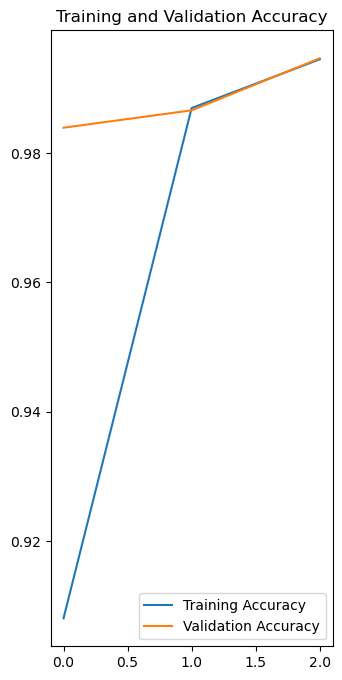

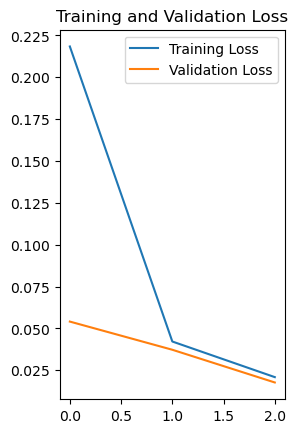

In [95]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(3), acc, label='Training Accuracy')
plt.plot(range(3), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


plt.subplot(1, 2, 2)
plt.plot(range(3), loss, label='Training Loss')
plt.plot(range(3), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Making predictions with test images.

In [97]:
predictions = model.predict(test_set)

2/2 [==============================] - 47s 6s/step


In [98]:
y_pred = np.argmax(predictions, axis=-1)

In [99]:
test_set.class_indices

{'Bell pepper Bacterial spot': 0, 'Bell pepper Healthy': 1}

In [122]:
predictions

array([[9.9996787e-01, 3.2096174e-05],
       [9.0030295e-01, 9.9697061e-02],
       [3.9490513e-03, 9.9605095e-01],
       [1.1965028e-08, 9.9999994e-01],
       [9.9998707e-01, 1.2918936e-05],
       [9.9999994e-01, 4.3026824e-10],
       [1.3050124e-03, 9.9869490e-01],
       [2.8340378e-01, 7.1659619e-01],
       [1.4025264e-02, 9.8597473e-01],
       [1.3601331e-01, 8.6398667e-01],
       [9.9998277e-01, 1.7184686e-05],
       [4.0429132e-03, 9.9595714e-01],
       [9.9999994e-01, 2.0785005e-09],
       [9.9999493e-01, 5.0627978e-06],
       [3.9988570e-02, 9.6001154e-01],
       [2.1186614e-04, 9.9978805e-01],
       [9.9999928e-01, 6.9172063e-07],
       [1.5811072e-01, 8.4188926e-01],
       [4.7093644e-04, 9.9952912e-01],
       [6.7029133e-02, 9.3297088e-01],
       [9.9980026e-01, 1.9980496e-04]], dtype=float32)

In [128]:
df = pd.DataFrame(y_pred, test_set.classes)
df

,0
0,0
0,0
0,1
0,1
0,0
0,0
0,1
0,1
0,1
0,1


We want to evaluate our model's performance with the test images. 

Our model has roughly 81% accuracy with test set. 

In [121]:
scores = model.evaluate(test_set,  batch_size=16, verbose=2)

2/2 - 28s - loss: 0.3235 - accuracy: 0.8095 - 28s/epoch - 14s/step


### Conclusion.

This is an attempt at fine-tuning a pre-trained VGG16 model. There's definitely room for improvement. 
1. We can add more layers to the frozen vgg16 layers.
2. We can increase the number of trainable layers.